In [1]:
import torch
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

import scgenome.plotting as pl

import simul
from tests.utils_testing import get_tree_K_nodes_one_level
from utils.config import Config, set_seed
from variational_distributions.joint_dists import FixedTreeJointDist
from variational_distributions.var_dists import qMuTau, qCMultiChrom, qZ, qEpsilonMulti, qPi
%matplotlib inline

set_seed(101)

/Users/haraldme/miniconda3/envs/victree/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/haraldme/miniconda3/envs/victree/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/haraldme/miniconda3/envs/victree/lib/python3.10/site-

In [4]:
M = 500
K = 5
A = 7
N = 200
n_iter = 100
n_datasets = 2

# set params
a0 = 20.
b0 = 1000.

nu0 = 1.
lambda0 = 10.
alpha0 = 500.
beta0 = 50.

delta0 = 10.


simulating dataset...


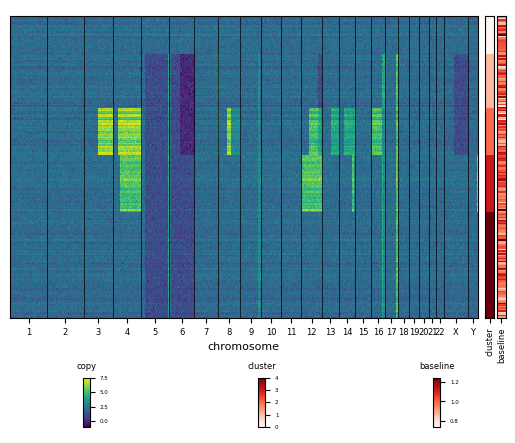

In [5]:
# simulate datasets
print("simulating dataset...")
config = Config(n_cells=N, n_nodes=K, n_states=A, chain_length=M, n_run_iter=n_iter, debug=True, step_size=0.08)
# for dsi in range(n_datasets):
fix_joint_q, sim_adata = simul.generate_dataset_var_tree(config, chrom='real', ret_anndata=True,
                                                         nu_prior=nu0, lambda_prior=lambda0, 
                                                         alpha_prior=alpha0, beta_prior=beta0,
                                                         eps_a=a0, eps_b=b0, dir_alpha=delta0)

sim_adata.obs['cluster'] = fix_joint_q.z.true_params['z'].numpy()
sim_adata.layers['state'] = fix_joint_q.c.true_params['c'].numpy()[sim_adata.obs['cluster']]
sim_adata.obs['baseline'] = fix_joint_q.mt.true_params['mu'].numpy()
g = pl.plot_cell_cn_matrix_fig(sim_adata, 'copy', annotation_fields=['cluster', 'baseline'], cell_order_fields=['cluster'], raw=True)

Fig: simulated reads together with true clustering and baseline.

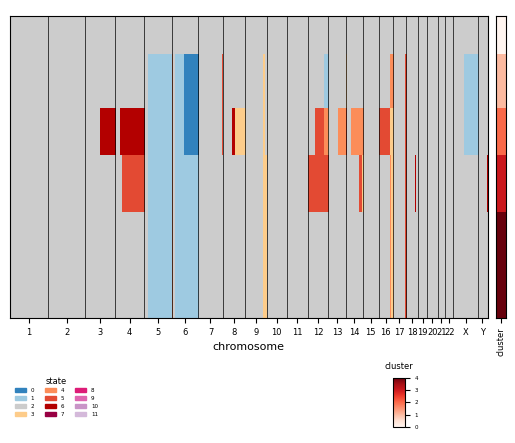

In [6]:
g = pl.plot_cell_cn_matrix_fig(sim_adata, 'state', annotation_fields=['cluster'], cell_order_fields=['cluster'], max_cn=config.n_states)

Fig. True copy number signal for each cluster.

In [7]:
# set up qmt, cell-qc
n_iter = 100

cell_config = Config(n_cells=N, n_nodes=N+1, n_states=A, n_run_iter=n_iter, step_size=0.2,
                     chain_length=config.chain_length, chromosome_indexes=config.chromosome_indexes, debug=True)
cell_qmt = qMuTau(cell_config, nu_prior=1., lambda_prior=1000., alpha_prior=5000., beta_prior=500.)
cell_qmt.initialize(method='prior')

cell_qc = qCMultiChrom(cell_config)
cell_qc.initialize(method='random')

cell_qeps = qEpsilonMulti(cell_config, alpha_prior=1., beta_prior=1.)
cell_qeps.initialize(method='prior')

In [8]:
# run inference with qmt,cell-qc
fixed_z = torch.arange(1, N + 1)
cell_qz_fix = qZ(cell_config, true_params={'z': fixed_z})
cell_tree = get_tree_K_nodes_one_level(N + 1)

print("running inference...")
for i in range(n_iter):
    cell_qmt.update(cell_qc, cell_qz_fix, fix_joint_q.obs)
    cell_qc.update(fix_joint_q.obs, cell_qeps, cell_qz_fix, cell_qmt,
                   [cell_tree], [1.])
    cell_qeps.update([cell_tree], torch.tensor([1.]), cell_qc)
    if (i+1) % 10 == 0:
        print(f"it {i}, elbo {cell_qc.compute_elbo([cell_tree], [1.], q_eps=cell_qeps)}")


running inference...
it 9, elbo -82357.07690429688
it 19, elbo -69359.35626220703
it 29, elbo -45690.30261230469
it 39, elbo -31910.061889648438
it 49, elbo -24653.09945678711
it 59, elbo -20541.529357910156
it 69, elbo -18094.084411621094
it 79, elbo -16612.141830444336
it 89, elbo -15660.75715637207
it 99, elbo -15082.953155517578


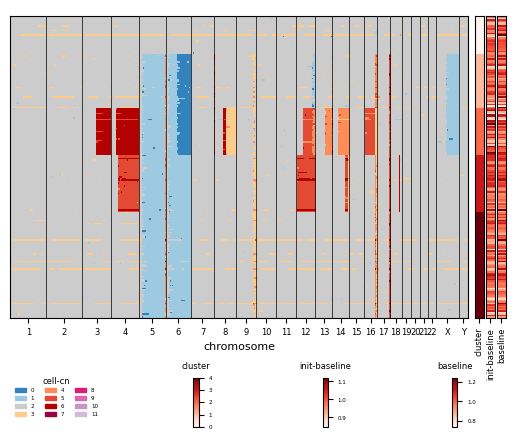

In [9]:
# after inference on cells specific cn
sim_adata.layers['cell-cn'] = cell_qc.get_viterbi()[1:].numpy()
sim_adata.obs['init-baseline'] = cell_qmt.nu.numpy()
g = pl.plot_cell_cn_matrix_fig(sim_adata, 'cell-cn', annotation_fields=['cluster', 'init-baseline', 'baseline'], cell_order_fields=['cluster'], max_cn=config.n_states)

Fig. Cell-specific copy number profile when qMuTau and cell-qC are jointly inferred for initialization

In [10]:
print("running k-means")
# cluster copy numbers with kmeans (on viterbi)
kmeans = KMeans(n_clusters=K, random_state=0).fit(cell_qc.get_viterbi()[1:])
c_labels = kmeans.labels_

print(f"ARI for KMeans after cell-cn estimation: {adjusted_rand_score(c_labels, fix_joint_q.z.true_params['z'].numpy())}")

# cluster copy numbers with kmeans (on viterbi)
obs_kmeans = KMeans(n_clusters=K, random_state=0).fit(fix_joint_q.obs.T.numpy())
obs_labels = obs_kmeans.labels_

print(f"ARI for KMeans with obs: {adjusted_rand_score(obs_labels, fix_joint_q.z.true_params['z'].numpy())}")


running k-means
ARI for KMeans after cell-cn estimation: 1.0
ARI for KMeans with obs: 0.6111941644933206


In [11]:
# initialize new qc with average
# build eta1 and eta2 from cell_qc
qc = qCMultiChrom(config)

for i, chr_qc in enumerate(qc.qC_list):
    # init for each chromosome the average tensor
    avg_param = {'eta1': torch.empty_like(chr_qc.eta1), 'eta2': torch.empty_like(chr_qc.eta2)}
    for k in range(K):
        cells_k = c_labels == k
        # average of eta parameters over cells assigned to the same cluster
        avg_param['eta1'][k, ...] = cell_qc.qC_list[i].eta1[1:][cells_k].mean(dim=0)
        avg_param['eta2'][k, ...] = cell_qc.qC_list[i].eta2[1:][cells_k].mean(dim=0)
    # normalization step
    avg_param['eta1'] = avg_param['eta1'] - torch.logsumexp(avg_param['eta1'], dim=-1, keepdim=True)
    avg_param['eta2'] = avg_param['eta2'] - torch.logsumexp(avg_param['eta2'], dim=-1, keepdim=True)

    chr_qc.initialize(method='fixed', **avg_param)

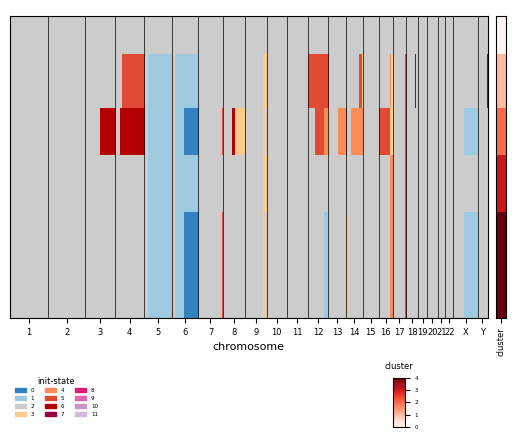

In [12]:
# inspect current state of new qC
sim_adata.layers['init-state'] = qc.get_viterbi().numpy()[sim_adata.obs['cluster']]
g = pl.plot_cell_cn_matrix_fig(sim_adata, 'init-state', annotation_fields=['cluster'], cell_order_fields=['cluster'], max_cn=config.n_states)

In [13]:
stable_zero = 1e-2
# initialize new qz (with current clustering) and new qeps
qz = qZ(config)
pi_init = torch.nn.functional.one_hot(torch.tensor(c_labels).long(), num_classes=config.n_nodes)
pi_init_smooth = torch.empty_like(pi_init, dtype=torch.float)
pi_init_smooth[pi_init == 1] = 1 - stable_zero
pi_init_smooth[pi_init == 0] = stable_zero / (config.n_nodes - 1)
# qz.initialize(z_init='fixed', pi_init=pi_init)
qz.initialize(z_init='fixed', pi_init=pi_init_smooth)

qpi = qPi(config)
cell_counts = np.unique(c_labels, return_counts=True)[1]
concentration_param_init = torch.tensor(cell_counts)
qpi.initialize(method='fixed', concentration_param_init=concentration_param_init)

qeps = qEpsilonMulti(config, alpha_prior=a0, beta_prior=b0)
qeps.initialize(method='prior')

qmt = qMuTau(config, nu_prior=1., lambda_prior=10., alpha_prior=50., beta_prior=5.)
qmt.initialize(method='fixed', loc=cell_qmt.nu, precision_factor=cell_qmt.lmbda, shape=cell_qmt.alpha, rate=cell_qmt.beta)

In [14]:
print("few more updates for qc and qmt after clustering...")
treeK = get_tree_K_nodes_one_level(config.n_nodes)

for i in range(100):
    qeps.update([treeK], [1.], qc)
    qc.update(fix_joint_q.obs, qeps, qz, qmt, [treeK], [1.])
    qmt.update(qc, qz, fix_joint_q.obs)

few more updates for qc and qmt after clustering...


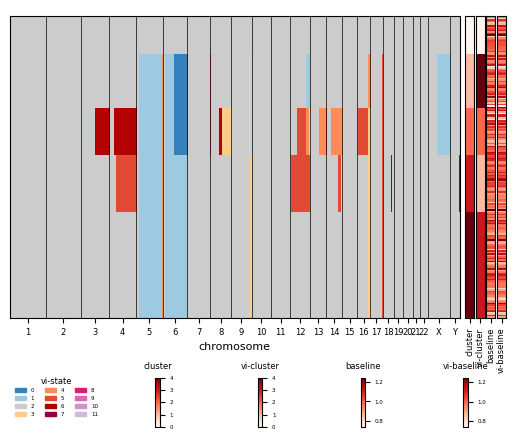

In [15]:
sim_adata.obs['vi-cluster'] = qz.pi.argmax(dim=-1).numpy()
sim_adata.layers['vi-state'] = qc.get_viterbi().numpy()[sim_adata.obs['vi-cluster']]
sim_adata.obs['vi-baseline'] = qmt.nu.numpy()
g = pl.plot_cell_cn_matrix_fig(sim_adata, 'vi-state', annotation_fields=['cluster', 'vi-cluster', 'baseline', 'vi-baseline'], cell_order_fields=['cluster'], max_cn=7)

In [16]:
print("running inference post init...")
joint = FixedTreeJointDist(config, qc, qz, qeps, qmt, qpi, treeK, fix_joint_q.obs)
for i in range(100):
    joint.update(it = i)
    if (i+1) % 10 == 0:
        print(f"it {i}, elbo {joint.elbo}")
        

running inference post init...
it 9, elbo -31369.087890625
it 19, elbo -29994.216796875
it 29, elbo -29370.361328125
it 39, elbo -29098.779296875
it 49, elbo -28979.404296875
it 59, elbo -28926.369140625
it 69, elbo -28904.935546875
it 79, elbo -28896.46484375
it 89, elbo -28890.978515625
it 99, elbo -28888.509765625


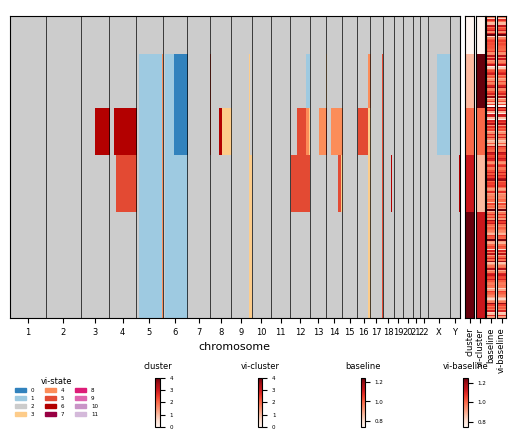

In [17]:
sim_adata.obs['vi-cluster'] = qz.pi.argmax(dim=-1).numpy()
sim_adata.layers['vi-state'] = qc.get_viterbi().numpy()[sim_adata.obs['vi-cluster']]
sim_adata.obs['vi-baseline'] = qmt.nu.numpy()
g = pl.plot_cell_cn_matrix_fig(sim_adata, 'vi-state', annotation_fields=['cluster', 'vi-cluster', 'baseline', 'vi-baseline'], cell_order_fields=['cluster'], max_cn=7)

## ISSUE

No cells are assigned to the healthy clone, and similar clusters are confounded.
When running qMuTau and cell-qC jointly in the beginning, it's easy for the algorithm
to find optima in mu that are smaller/larger than the true mu, while offsetting the
copy number accordingly. This can be avoided by using HMMcopy profile instead as an
initialization step. 